# Vaccine Myths ML Notebook

## Data import from Kaggle

In [1]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("gpreda/reddit-vaccine-myths")
df = pd.read_csv(f"{path}\\reddit_vm.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


## Data preparation with SpaCy

In [2]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")

def clean(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r"http\S+ | www\S+", "", text) # deleting URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text) # deleting everything beside letters and spaces
    
    return text.lower().strip()

def norm(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

df["clean_txt"] = df["body"].apply(clean).apply(norm)
df = df[df["clean_txt"].str.len() > 10]
df.head()

,title,score,id,url,comms_num,created,body,timestamp,clean_txt
6,Comment,1,ej9x066,NaN,0,1.553474e+09,Your OP. It's not a myth. Only one vaccine con...,2019-03-25 02:34:53,op myth vaccine contain op pointless flex
7,Fuck you anti-vaxxing retards,10,g6jkhp,https://www.reddit.com/r/VaccineMyths/comments...,8,1.587663e+09,https://youtu.be/zBkVCpbNnkU,2020-04-23 20:23:42,httpsyoutubezbkvcpbnnku
8,Comment,0,fofa0yy,NaN,0,1.587760e+09,Because Anti-Vaxxers have no sense,2020-04-24 23:19:50,antivaxxer sense
9,Comment,0,ej9xuaf,NaN,0,1.553475e+09,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21,mean op fairly new reddit
10,Comment,1,ej9x2qr,NaN,0,1.553474e+09,"When they say there's no thimerasol, they mean...",2019-03-25 02:35:47,s thimerasol mean childhood schedule fact


## Labelling data

In [3]:
myth_keywords = ["autism", "microchip", "toxic", "conspiracy", "5g", "gates", "government"]
fact_keywords = ["safe", "effective", "study", "research", "proven", "tested"]

def assign_label(text):
    text = text.lower()
    if any(word in text for word in myth_keywords):
        return "myth"
    elif any(word in text for word in fact_keywords):
        return "fact"
    else:
        return None

df["label"] = df["clean_txt"].apply(assign_label)
df = df.dropna(subset=["label"])

print(f"Myth: {(df['label'] == 'myth').sum()}")
print(f"Fact: {(df['label'] == 'fact').sum()}")
print(f"Imbalance ratio: {(df['label'] == 'myth').sum() / (df['label'] == 'fact').sum():.2f}")

Myth: 152
Fact: 124
Imbalance ratio: 1.23


## Embedding with Flair framework

In [4]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
import numpy as np
from tqdm import tqdm

embedder = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=False)

def get_embedding(text):
    sentence = Sentence(text)
    embedder.embed(sentence)
    return sentence.embedding.detach().numpy()

X = np.vstack([get_embedding(t) for t in tqdm(df["clean_txt"])])
y = df["label"].values

100%|██████████| 276/276 [00:15<00:00, 17.83it/s]


## Logistic Regression

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

clf = LogisticRegression(max_iter=256, random_state=1410)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1410)

acc, f1 = [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc.append(accuracy_score(y_test, preds))
    f1.append(f1_score(y_test, preds, pos_label="myth"))

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        fact       0.74      0.71      0.72        24
        myth       0.78      0.81      0.79        31

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55



## Different models comparison

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

clfs = {
    'LR': LogisticRegression(max_iter=500),
    'SVM': SVC(kernel="rbf", random_state=1410),
    'RF': RandomForestClassifier(n_estimators=100, random_state=1410),
    'GNB': GaussianNB()
}

results = {}

for name, clf in clfs.items():
    acc, f1 = [], []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        
        acc.append(accuracy_score(y_test, preds))
        f1.append(f1_score(y_test, preds, pos_label="myth"))
    
    results[name] = {'acc': np.mean(acc), 'f1': np.mean(f1)}
    print(f"{name:5s} -> Acc: {np.mean(acc):.3f}, F1: {np.mean(f1):.3f}")

LR    -> Acc: 0.743, F1: 0.768
SVM   -> Acc: 0.667, F1: 0.747
RF    -> Acc: 0.678, F1: 0.719
GNB   -> Acc: 0.652, F1: 0.688


## Plots

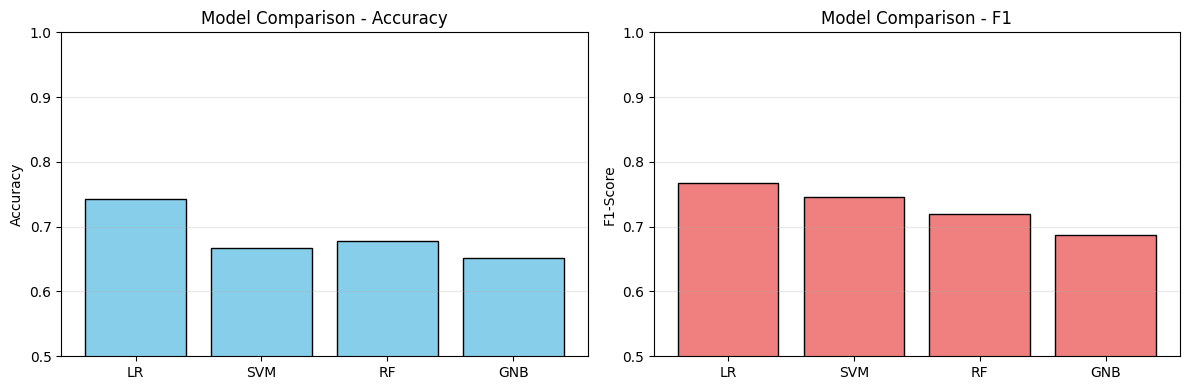

In [7]:
import matplotlib.pyplot as plt

names = list(results.keys())
accs = [results[n]['acc'] for n in names]
f1s = [results[n]['f1'] for n in names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(names, accs, color='skyblue', edgecolor='black')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Comparison - Accuracy')
ax1.set_ylim([0.5, 1.0])
ax1.grid(axis='y', alpha=0.3)

ax2.bar(names, f1s, color='lightcoral', edgecolor='black')
ax2.set_ylabel('F1-Score')
ax2.set_title('Model Comparison - F1')
ax2.set_ylim([0.5, 1.0])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()